# Doctor Consultantcy Fees Prediction

### Description About Data**
**In the data, we have the following columns to work with :**
1. Qualification: Qualification and degrees held by the doctor
2. Experience: Experience of the doctor (number of years)
3. Rating: Rating given by patients
4. Profile: Type of the doctor
5. Miscellaeous_Info: Extra information about the doctor
6. Place: Area and the city where the doctor is located
7. Fees: Fees charged by the doctor(Target)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import some python modules
import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option("display.max_columns",None)

**Importing Dataset**
* Since Data is in excel format so we will use pd.read_excel func to read data.
* After loading the data, it is important to have basic understanding about the data like shape, info and basic understanding of presence of null values in data.

In [3]:
train = pd.read_excel('Final_Train.xlsx')
test = pd.read_excel('Final_Test.xlsx')

In [4]:
#shape of train & test set
print("training_data shape",train.shape)
print("testing_data shape",test.shape)

training_data shape (5961, 7)
testing_data shape (1987, 6)


In [5]:
# look over data
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


In [6]:
# check for NULL values
round(train.isnull().sum() / len(train) * 100, 2)

Qualification          0.00
Experience             0.00
Rating                55.39
Place                  0.42
Profile                0.00
Miscellaneous_Info    43.95
Fees                   0.00
dtype: float64

## EDA
**There will be lot's of analysis which can be assumed by observing our data as all the feature we are having is categorical even experience, except target variable(Fees) so let's begin..**

In [7]:
# Extract Experience Year from Experience column And convert it into Numeric

train['Experience'] = train['Experience'].str.split().str[0]
train['Experience'] = train['Experience'].astype(int)

In [8]:
train.head(2)

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350


**2) Moving with Place Column**
* As, there are some missing values in Place column so I have replaced then with Unknown, Unknown to represent them.
* then, we can easily extract city and locality from Place variable.

In [9]:
train['Place'].fillna('Unknown,Unknown', inplace=True)

train['locality'] = train['Place'].str.split(",").str[0]
train['city'] = train['Place'].str.split(",").str[1]

#Now, we can drop the Place Column
train.drop('Place',axis=1,inplace=True)

**3) Rating Column**

Rating has more then 50% of missing values so first we have to deal with them, so we will fill the rating with respect to Profile column having mean rating, then convert Rating to int.

In [10]:
# Fill the missing Values in Ratingcolumn with -1% to provide importance to missing value.
train['Rating'].fillna('-1%',inplace=True)

In [11]:
# Now, Extract the actual value of Rating except '%' sign
train['Rating'] = train['Rating'].str.slice(stop=-1).astype(int)

# Alternate way to do this,
#train['Rating'] = train['Rating'].apply(lambda x: str(x).replace('%','')).astype(int)

In [12]:
train.head(3)

,Qualification,Experience,Rating,Profile,Miscellaneous_Info,Fees,locality,city
0,"BHMS, MD - Homeopathy",24,100,Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,Kakkanad,Ernakulam
1,"BAMS, MD - Ayurveda Medicine",12,98,Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,Whitefield,Bangalore
2,"MBBS, MS - Otorhinolaryngology",9,-1,ENT Specialist,NaN,300,Mathikere - BEL,Bangalore


**Now, I grouped the rating in 10 groups (bins of size 10). Values less then 0 (Missing Values) will fall under 0 group. while, 0-9% will be class 1, 10–19% will be class 2, so on and so forth.
**we will use pd.cut() for this.**
* Use pandas cut() when you need to segment and sort data values into bins. For example, cut could convert ages to groups of age ranges. Supports binning into an equal number of bins, or a pre-specified array of bins.

In [13]:
print("less then 0%",len(train[train['Rating']<0]))
print("0-9%",len(train[(train['Rating']>0) & (train['Rating']<10)]))
print("10-19%",len(train[(train['Rating']>=10) & (train['Rating']<20)]))
print("20-29%",len(train[(train['Rating']>=20) & (train['Rating']<30)]))
print("30-29%",len(train[(train['Rating']>=30) & (train['Rating']<40)]))
print("And so on..")

less then 0% 3302
0-9% 1
10-19% 0
20-29% 0
30-29% 3
And so on..


In [14]:
bins = [-1,0,10,20,30,40,50,60,70,80,90,100]   #bins takes 1 fewer value then labels
labels = [i for i in range(11)]
train['Rating'] = pd.cut(train['Rating'], bins=bins, labels=labels, include_lowest=True)

In [15]:
train['Rating'].value_counts().sort_index()

0     3302
1        1
2        0
3        0
4        4
5        3
6       19
7       32
8       98
9      280
10    2222
Name: Rating, dtype: int64

**working with Qualification Column**

In [16]:
# number of qualification done by one doctor
train['Qualification_count'] = train['Qualification'].apply(lambda x: len(x.split(",")))

train['Qualification_count'].value_counts()

2     2628
1     1962
3      995
4      257
5       84
6       23
7        6
9        3
8        2
10       1
Name: Qualification_count, dtype: int64

In [17]:
# max 10 qual is done by 1 doctor, let's have a look 
train[train['Qualification_count'] == 10]

,Qualification,Experience,Rating,Profile,Miscellaneous_Info,Fees,locality,city,Qualification_count
2035,"Fellowship in Oral implantlogy, Certified Adva...",22,10,Dentist,RCT - Root Canal Treatment Cosmetic/ Aesthetic...,300,Ashok Nagar,Chennai,10


In [18]:
train['Qualification'].nunique()

1420

* here there are lot of Qualification but most of doctors only has 1 or 2 qualification. 
* And the data is to much messy like, ` 'MBA -Healthcare' and ‘MBA’` which referred to same category so here we will take the top 10 Qualification that occurs the most.

In [19]:
# Dict of each Qualification with their counts
train['Qualification'] = train['Qualification'].str.split(",")
Qualification = {}

for x in train['Qualification'].values:
    for qual in x:
        qual = qual.strip()
        if qual in Qualification:
            Qualification[qual] += 1
        else:
            Qualification[qual] = 1

#print(Qualification)

In [20]:
# Now, Extract Top 10 Qual from Qualification
most_qual = sorted(Qualification.items(), key=lambda x: x[1], reverse=True)[:10]
final_qual = []

for qual in most_qual:
    final_qual.append(qual[0])

print(final_qual)

['MBBS', 'BDS', 'BAMS', 'BHMS', 'MD - Dermatology', 'MS - ENT', 'Venereology & Leprosy', 'MD - General Medicine', 'Diploma in Otorhinolaryngology (DLO)', 'MD - Homeopathy']


In [21]:
# Encode extracted top 10 qualification into train dataset as new column.
for qual in final_qual:
    train[qual] = 0
    
for x,y in zip(train['Qualification'].values, np.array([i for i in range(len(train))])):
    for c in x:
        c = c.strip()
        if c in final_qual:
            train[c][y] = 1

In [22]:
# drop the column which are note required now,
train.drop(['Qualification','Qualification_count'],axis=1, inplace=True)

In [23]:
train.head()

,Experience,Rating,Profile,Miscellaneous_Info,Fees,locality,city,MBBS,BDS,BAMS,BHMS,MD - Dermatology,MS - ENT,Venereology & Leprosy,MD - General Medicine,Diploma in Otorhinolaryngology (DLO),MD - Homeopathy
0,24,10,Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,Kakkanad,Ernakulam,0,0,0,1,0,0,0,0,0,1
1,12,10,Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,Whitefield,Bangalore,0,0,1,0,0,0,0,0,0,0
2,9,0,ENT Specialist,NaN,300,Mathikere - BEL,Bangalore,1,0,0,0,0,0,0,0,0,0
3,12,0,Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,Bannerghatta Road,Bangalore,0,0,1,0,0,0,0,0,0,0
4,20,10,Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,Keelkattalai,Chennai,0,0,1,0,0,0,0,0,0,0


**Interpretation**
* Now, we can see that we are having top 10 Qual columns in our training set which are perfectly one-hot encoded. where there is 2 Qual from top 10 in that row two 1 are there, and it's correct.

**City Column**

In [24]:
train['city'].unique()

array([' Ernakulam', ' Bangalore', ' Chennai', ' Delhi', ' Hyderabad',
       ' Coimbatore', ' Mumbai', ' Thiruvananthapuram', 'Unknown',
       ' Sector 5', nan], dtype=object)

In [25]:
# remove the extra Spaces from the city
train['city'] = train['city'].apply(lambda x: re.sub(' +','',str(x)))

train['city'].value_counts()

Bangalore             1258
Mumbai                1219
Delhi                 1184
Hyderabad              951
Chennai                855
Coimbatore             228
Ernakulam              153
Thiruvananthapuram      86
Unknown                 25
Sector5                  1
nan                      1
Name: city, dtype: int64

In [26]:
# there are some mis-entry in city column, let's find it out
train[(train['city'] == 'Sector5') | (train['city'] == 'nan')]

,Experience,Rating,Profile,Miscellaneous_Info,Fees,locality,city,MBBS,BDS,BAMS,BHMS,MD - Dermatology,MS - ENT,Venereology & Leprosy,MD - General Medicine,Diploma in Otorhinolaryngology (DLO),MD - Homeopathy
2169,11,0,Dentist,NaN,250,Dwarka,Sector5,0,1,0,0,0,0,0,0,0,0
3980,23,0,Dentist,NaN,250,e,nan,0,1,0,0,0,0,0,0,0,0


* whereever the locality is Dwarka the city is Delhi, and this Sector5 is area of that so it's misclassified here. which we have to correct.
* And where city is nan there we have to impute this to unknown in locality and city both.

In [27]:
train['city'] = np.where(train['city'] == "Sector5", "Delhi", train['city'])

train['locality'][3980] = "Unknown"
train['city'][3980] = "Unknown"

In [28]:
# let's see for each city how many locality are there
train.groupby('city')['locality'].nunique().reset_index()

,city,locality
0,Bangalore,153
1,Chennai,124
2,Coimbatore,48
3,Delhi,200
4,Ernakulam,52
5,Hyderabad,135
6,Mumbai,115
7,Thiruvananthapuram,48
8,Unknown,1


### Data Visualization & Categorical Encoding
**Before encoding a categorical variable, look at relationship of data with respect to target column To have better understand the data**

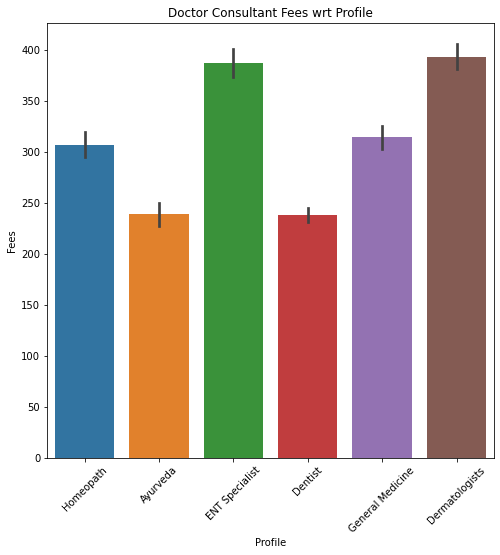

In [29]:
plt.figure(figsize=(8,8))
sns.barplot(x='Profile',y='Fees',data=train)
plt.title("Doctor Consultant Fees wrt Profile")
plt.xticks(rotation=45)
plt.show()

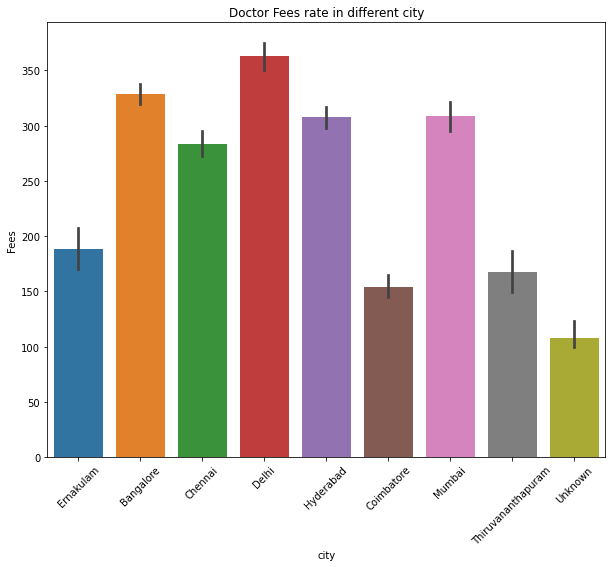

In [30]:
plt.figure(figsize=(10,8))
sns.barplot(x='city',y='Fees',data=train)
plt.title("Doctor Fees rate in different city")
plt.xticks(rotation=45)
plt.show()

**Observations**
* As Delhi, Banglore, Hyderabad, Mumbai and Chennai are in list of Tier 1 city so, as usual the doctor consultation fees in these metripolean cities are very high as compared to Tier 2 and Tier 3 city.
* Doctor Fees with having profile as ENT Specialist and Dermatologist is very high then Homeopath and General medicine.

In [31]:
# encode Profile and city
train = pd.get_dummies(train, columns=['city','Profile'], prefix=['city','Profile'])

In [32]:
train.head(3)

,Experience,Rating,Miscellaneous_Info,Fees,locality,MBBS,BDS,BAMS,BHMS,MD - Dermatology,MS - ENT,Venereology & Leprosy,MD - General Medicine,Diploma in Otorhinolaryngology (DLO),MD - Homeopathy,city_Bangalore,city_Chennai,city_Coimbatore,city_Delhi,city_Ernakulam,city_Hyderabad,city_Mumbai,city_Thiruvananthapuram,city_Unknown,Profile_Ayurveda,Profile_Dentist,Profile_Dermatologists,Profile_ENT Specialist,Profile_General Medicine,Profile_Homeopath
0,24,10,"100% 16 Feedback Kakkanad, Ernakulam",100,Kakkanad,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,12,10,"98% 76 Feedback Whitefield, Bangalore",350,Whitefield,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,9,0,NaN,300,Mathikere - BEL,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [33]:
#train.columns

In [34]:
#change the name of some columns to use it in correct way.
train.rename(columns={'MD - Dermatology':'MD_Dermatology','MS - ENT':'MS_ENT','Venereology & Leprosy':'Venereology_Leprosy',
                      'MD - General Medicine':'MD_General_Medicine','Diploma in Otorhinolaryngology (DLO)':'Diploma_in_Otorhinolaryngology',
                      'MD - Homeopathy':'MD_Homeopathy','Profile_ENT Specialist':'Profile_ENT_Specialist',
                      'Profile_General Medicine':'Profile_General_Medicine'}, inplace=True)

**Miscellaneous_Info & locality**
* Miscellaneous_Info is to much messy column and it consist the data which we already have like doctor address(city & locality) and Rating
* locality and city are approximate have same relationship so better to move with only city
* so drop the Miscellaneous_Info and locality

In [35]:
train.drop(['Miscellaneous_Info','locality'], axis=1, inplace=True)

In [36]:
train.head(2)

,Experience,Rating,Fees,MBBS,BDS,BAMS,BHMS,MD_Dermatology,MS_ENT,Venereology_Leprosy,MD_General_Medicine,Diploma_in_Otorhinolaryngology,MD_Homeopathy,city_Bangalore,city_Chennai,city_Coimbatore,city_Delhi,city_Ernakulam,city_Hyderabad,city_Mumbai,city_Thiruvananthapuram,city_Unknown,Profile_Ayurveda,Profile_Dentist,Profile_Dermatologists,Profile_ENT_Specialist,Profile_General_Medicine,Profile_Homeopath
0,24,10,100,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,12,10,350,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


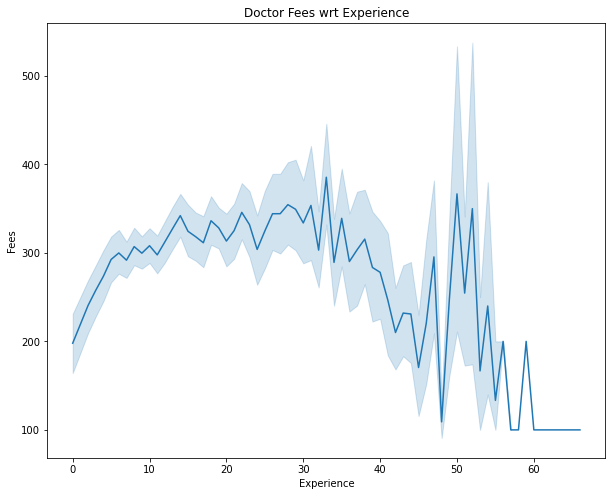

In [37]:
# Doctor Fees wrt to Experience
plt.figure(figsize=(10,8))
ax = sns.lineplot(x='Experience',y='Fees',data=train)
ax.set_title("Doctor Fees wrt Experience")
plt.show()

* most of us assumed that there is some association between the experience of the doctor and the fees they charged. Indeed there is, but it might not what we expect it to be. The average Fees increases from 25 years and is at peak near about 30 to 35. And Average Fees Decreases as there in further increase in Experience.

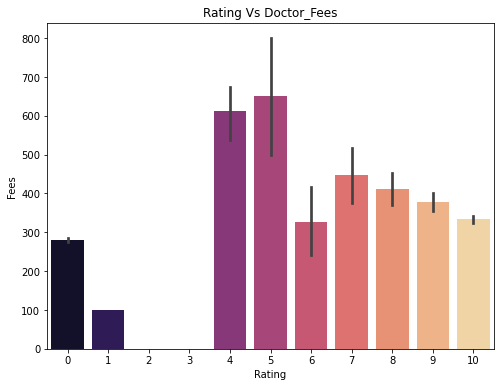

In [38]:
plt.figure(figsize=(8,6))
sns.barplot(x='Rating',y='Fees',data=train,palette='magma')
plt.title("Rating Vs Doctor_Fees")
plt.show()

**OBSERVATIONS**
* the Rating is interesting column, we have grouped the rating in 10 bins, eg: bin5 will be rating of 40-49%.
* As, we can see that High rating does not relate to high fees charged(infact low fees can be reason of high rating) and where fees are charged so high, there rating is between 30-60%.
* The median of experience in bin 4 & 5 is 27 and 31 years respectively. whereas in highest rating of 10th bin the median experience is 14 years. 

## TEST DATA

In [39]:
# EXPERIENCE COLUMN
test['Experience'] = test['Experience'].str.split().str[0]
test['Experience'] = test['Experience'].astype(int)

#Place column (Extract city and locality in diff column)
test['Place'].fillna('Unknown,Unknown',inplace=True)
test['locality'] = test['Place'].str.split(",").str[0]
test['city'] = test['Place'].str.split(",").str[1]
#drop place column
test.drop('Place',axis=1,inplace=True)

#Rating column
test['Rating'].fillna('-1%',inplace=True)
test['Rating'] = test['Rating'].str.slice(stop=-1).astype(int)

# group rating in 10 groups, missing_value to group 0
bins = [-99,0,10,20,30,40,50,60,70,80,90,100]
labels = [int(i) for i in range(11)]
test['Rating'] = pd.cut(test['Rating'], bins=bins, labels=labels, include_lowest=True)

In [40]:
# QUALIFICATION COLUMN
# dict of qualification with counts
# HERE the top 10 Qual of train and test col should be same so I am imputing the train col to test col
data = pd.read_excel('Final_Train.xlsx')
data['Qualification'] = data['Qualification'].str.split(",")
Qualification = {}
for x in data['Qualification']:
    for each in x:
        each = each.strip()
        if each in Qualification:
            Qualification[each] += 1
        else:
            Qualification[each] = 1
            
# finding out the top 10 Qualification
most_qual = sorted(Qualification.items(), key=lambda x:x[1], reverse=True)[:10]
final_qual = []
for qual in most_qual:
    final_qual.append(qual[0])

#encode the top 10 qualification in test dataset
for title in final_qual:
    test[title] = 0

for x,y in zip(test['Qualification'].values, np.array([i for i in range(len(test))])):
    for c in x:
        c = c.strip()
        if c in final_qual:
            test[c][y] = 1
            
#drop Qualification after getting top 10 qual.
test.drop('Qualification',axis=1,inplace=True)


#city column
test['city'] = test['city'].apply(lambda x: re.sub(' +','',x))

#encode city and profile
test = pd.get_dummies(test, columns=['city','Profile'], prefix=['city','Profile'])

#drop Miscellaneous_Info and locality
test.drop(['Miscellaneous_Info','locality'], axis=1, inplace=True)

## Model Building
**Based on the hackathon site(MachineHack), submission are evaluated on Root-Mean-Squared-Log-Error (RMSLE) error, more specifically, 1-RMSLE. so, I will use metrics as RMSLE**

* RMSLE: techniques to find out the difference between the predicted values by model and the actual values. Only we take the log of predicted values and actual values

In [41]:
x = train.drop('Fees',axis=1)    #Independent Variables
y = train['Fees']                # Dependent Variables(Target)

In [42]:
# train-test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [43]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# to use RMSLE we will create our own scorer
from sklearn.metrics import make_scorer

In [44]:
# calculate RMSLE (SCORE func).
def score(y_pred,y):
    y_pred = np.log(y_pred)
    y = np.log(y)
    return 1 - ((np.sum((y_pred - y)**2)) / len(y))**1/2

# SCORING func for Cross Validation (RandomizedSearchCV)
scorer = make_scorer(score_func = score, greater_is_better=True)

In [45]:
# object of algo we have imported
knn_reg = KNeighborsRegressor()
svm_reg = SVR(gamma='scale')
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()

In [46]:
for reg in (knn_reg, svm_reg, dt_reg, rf_reg):
    reg.fit(x_train,y_train)
    
    y_pred = reg.predict(x_test)
    
    print(reg, score(y_pred,y_test))

KNeighborsRegressor() 0.7786915880135319
SVR() 0.7753298683985804
DecisionTreeRegressor() 0.6715982927373436
RandomForestRegressor() 0.7634683897269747


In [47]:
from sklearn.ensemble import VotingRegressor

In [48]:
voting_reg = VotingRegressor([('knn',knn_reg), ('svm',svm_reg), ('dt',dt_reg), ('rf',rf_reg)])

voting_reg.fit(x_train,y_train)

pred = voting_reg.predict(x_test)

print("score:",score(pred,y_test))

score: 0.782548136391377


In [49]:
# check with custom input.
fees = svm_reg.predict([[10,10,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0]])
print(round(fees[0],2))

295.82


**There is less parameter in Knn and after HyperParameter tuning the accuracy was 78.3. And after doing HyperParameter tuning of SVM the accuracy was 79.2. Thus, I move with RandomForest**

## HyperParameter Tuning for RandomForest

In [50]:
from sklearn.model_selection import RandomizedSearchCV

In [51]:
# hyperparameter tuning of RandomForest

#no. of tress random_forest
n_estimators = [int(x) for x in np.linspace(start=150,stop=1000,num=6)]
#max levels in tree
max_depth = [int(x) for x in np.linspace(start=6,stop=30,num=5)]
#min no. of splitting required to split a node
min_samples_split = [2,7,10]
#min no. of sample required at each leaf node
min_samples_leaf = [2,5,10]
#max_features
max_features=['auto','sqrt']

# generate a dictionary of all the Hyper Parameters
random_grid = {'n_estimators':n_estimators,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features':max_features,
              }

#print(random_grid)

In [52]:
# increase the n_iter for more accuracy.
rf_random = RandomizedSearchCV(rf_reg, param_distributions=random_grid, scoring=scorer, cv=5, n_iter=20, random_state=42, verbose=1, n_jobs=-1)

rf_random.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [6, 12, 18, 24, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 10],
                                        'min_samples_split': [2, 7, 10],
                                        'n_estimators': [150, 320, 490, 660,
                                                         830, 1000]},
                   random_state=42, scoring=make_scorer(score), verbose=1)

In [53]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 30}

In [54]:
rf_reg = RandomForestRegressor(n_estimators= 490, min_samples_split= 10, min_samples_leaf= 5, max_features= 'sqrt', max_depth= 24)

rf_reg.fit(x_train,y_train)

RandomForestRegressor(max_depth=24, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=490)

In [55]:
mypredi = rf_reg.predict(x_test)
print("score:",score(mypredi,y_test))

score: 0.7939326997413434


In [56]:
# check with custom input.
fees = rf_reg.predict([[10,10,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0]])
print(round(fees[0],2))

372.12


## Save The Model for further use

In [57]:
import pickle

In [60]:
file = open("doctorrf_fees.pkl",'wb')

#dump the model to that file
pickle.dump(rf_reg,file)

In [61]:
reg = pickle.load(open('doctorrf_fees.pkl','rb'))

In [62]:
y_pred = reg.predict(x_test)

print("score:",score(y_pred,y_test))

score: 0.7939326997413434


In [63]:
# check with custom input.
fees = reg.predict([[10,10,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0]])
print(round(fees[0],2))

372.12
